In [1]:
from files.scene import *
from files.multiscene import *
from files.IN import *

# Data Creation

## Scene creation

In [36]:
#No interaction scene
escena_no_interaction = Scene(n_body=3, R_init=polygon_init, V_init=polygon_init, r=0.1, v=0.01, dt=1)
escena_no_interaction.simulate(interaction=zero_interaction, t_steps=100)

#Central force scene
escena_central_force = Scene(n_body=3, R_init=random_init, V_init=random_init, r=0.1, v=8e-3, dt=1)
escena_central_force.simulate(interaction=central_force, t_steps=100, alpha=1e-4, beta=0)

#Vicsek model scene
escena_vicsek = Scene(n_body=6,  R_init=random_init, V_init=random_init, r=0.6, v=1e-1, dt=1)
escena_vicsek.simulate(interaction=vicsek, t_steps=100, radius=0.4, angle_vision=np.pi)

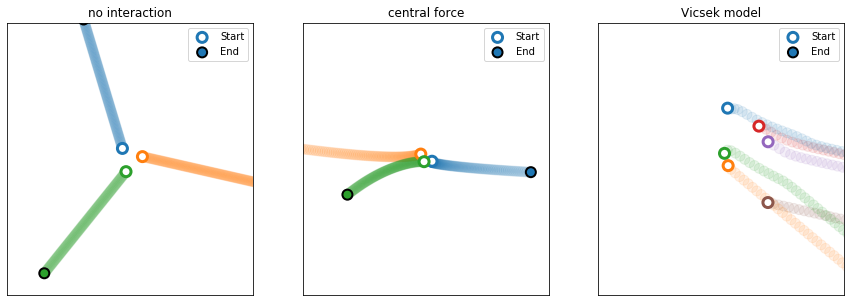

In [38]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

for axi, scene, title in zip(ax,[escena_no_interaction, escena_central_force, escena_vicsek], ['no interaction', 'central force', 'Vicsek model']):
    axi.set_xlim(-1,1)
    axi.set_ylim(-1,1)
    axi.set_title(title)
    axi.tick_params(labelbottom=False, labelleft=False, right=False, top=False, bottom=False, left=False)
    scene.plot_trajectory(who='truth', ax=axi)
    axi.legend()
plt.show()


## Multiscene creation

In [2]:
n_scenes = 3
t_steps = 100
ms = MultiScene()
ms.add_bunch(n_scenes=n_scenes, n_body=5, t_steps=100, R_init=random_init, V_init=random_init, dt=1, r=2e-1, v=5e-2, interaction=zero_interaction)
ms.add_bunch(n_scenes=n_scenes, n_body=5, t_steps=t_steps, R_init=random_init, V_init=random_init, dt=1, r=7.5e-1, v=8e-3, interaction=central_force, alpha=1e-4, beta=0)
ms.add_bunch(n_scenes=n_scenes, n_body=5, t_steps=t_steps, R_init=random_init, V_init=polygon_init, r=6e-1, v=1e-2, interaction=vicsek, radius=2.5e-1)
ms.save('data/demo_multiscene')

ms = MultiScene(load='data/demo_multiscene')

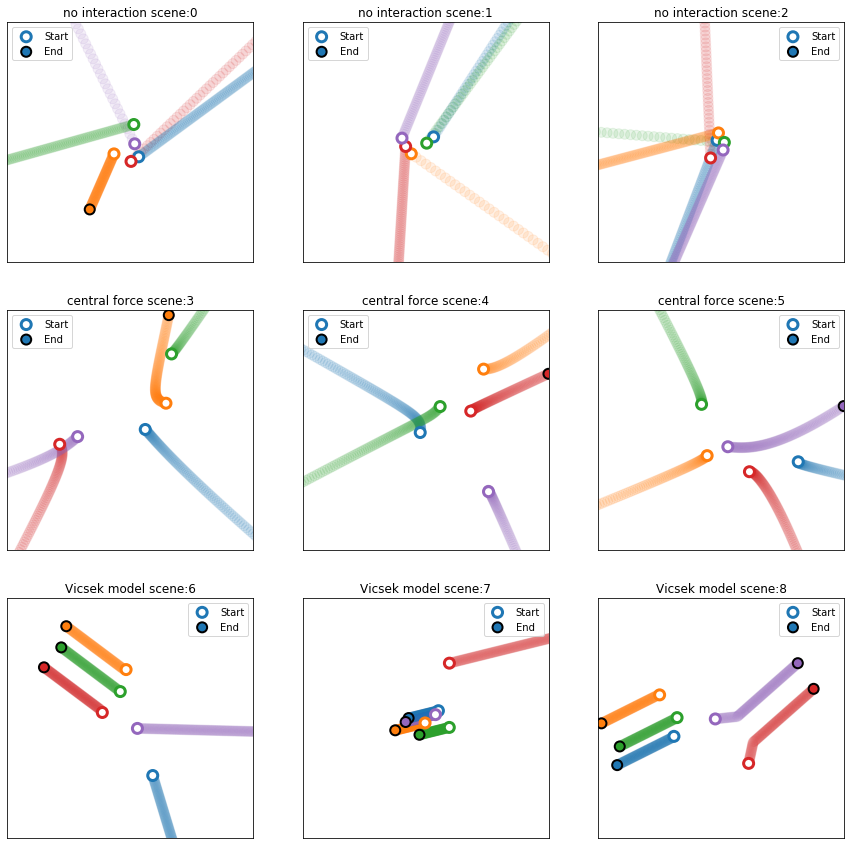

In [3]:
fig, ax = plt.subplots(3,3,figsize=(15,15))
scene_i = 0
for axi,title in zip(ax, ['no interaction', 'central force', 'Vicsek model']):
    for axij in axi:
        axij.set_xlim(-1,1)
        axij.set_ylim(-1,1)
        axij.set_title(title+ f' scene:{scene_i}')
        axij.tick_params(labelbottom=False, labelleft=False, right=False, top=False, bottom=False, left=False)
        ms(scene_i).plot_trajectory(who='truth', ax=axij)
        axij.legend()
        scene_i +=1
plt.show()


## Creating Training and Validation Datasets

In [57]:
n_scenes = 100
t_steps = 100
ms = MultiScene()
ms.add_bunch(n_scenes=n_scenes, n_body=5, t_steps=100, R_init=random_init, V_init=random_init, dt=1, r=4e-1, v=5e-2, interaction=zero_interaction)
ms.save('data/demo_train')

ms = MultiScene()
ms.add_bunch(n_scenes=n_scenes, n_body=5, t_steps=100, R_init=random_init, V_init=random_init, dt=1, r=2e-1, v=5e-2, interaction=zero_interaction)
ms.save('data/demo_val')

### Extracting the features and targets

In [4]:
ms_train = MultiScene(load='data/demo_train')
X_train = ms_train.get_features(joint=True) #features
V_train = ms_train.get_target(var='V', joint=True) #target velocities
A_train = ms_train.get_target(var='A', joint=True) #target accelerations

ms_val = MultiScene(load='data/demo_val')
X_val = ms_val.get_features(joint=True) #features
V_val = ms_val.get_target(var='V', joint=True) #target velocities
A_val = ms_val.get_target(var='A', joint=True) #target accelerations

# CREATING A MODEL

## Training

In [5]:
IN = InteractionNetwork(D_E=2, R_hidden_layers=[], O_hidden_layers=[], output_var='A', self_edges=False,  aggregator='sum', include_v=False, name='demo_model')
IN.fit(X_train, A_train, validation=(X_val, A_val), learning_rate=1e-1, epochs=10000, print_every=100)
IN.save('saved_models/'+IN._name)
IN = InteractionNetwork(load='saved_models/demo_model')

### Visualizing the loss evolution for training and validation

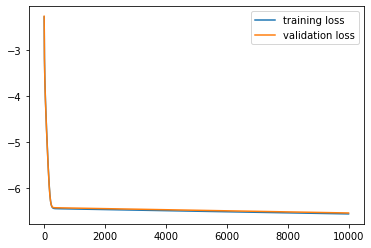

In [6]:
plt.plot([np.log10(x) for x in IN.history['loss']], label='training loss')
plt.plot([np.log10(x) for x in IN.history['validation']], label='validation loss')
plt.legend()
plt.show()

### Computing position MSE for different length mulstistep rollout predictions

In [72]:
ms_val.predict_trajectory(IN)
ms_val.compute_mse()
ms_val.save('data/demo_val')

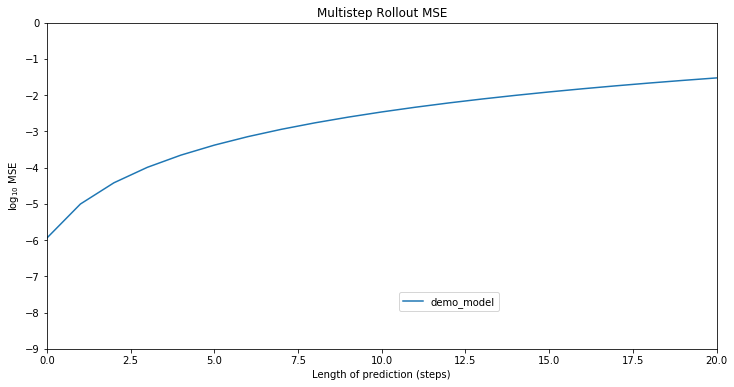

In [7]:
fig, ax = plt.subplots( figsize=(12,6.))
ms_val.plot_mse(ax=ax)
ax.legend(loc="lower center", bbox_to_anchor=(0.6, 0.1), ncol=2)
ax.set_ylim(top=-0, bottom=-9)
ax.set_xlim(right=20, left=0)
plt.show()

### Visualizing multistep rollout predictions

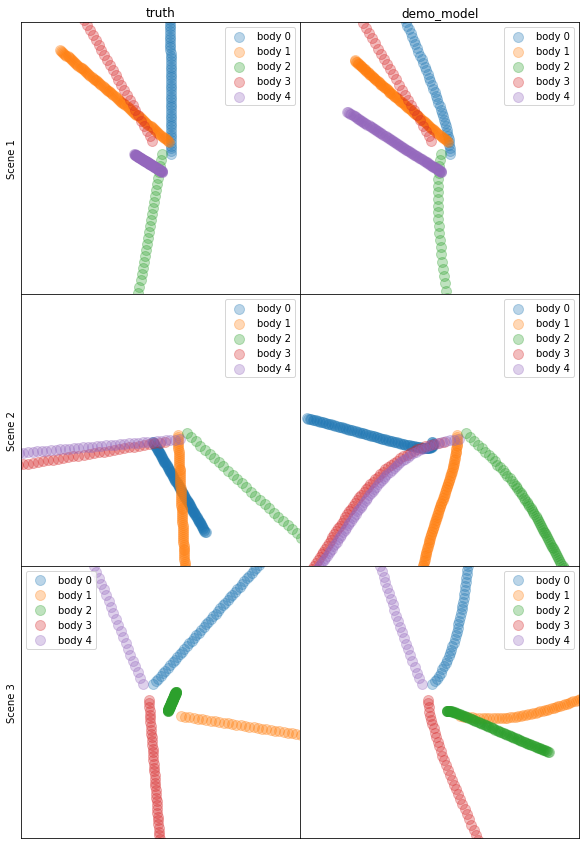

In [10]:
n_scenes = 3
hspace = 0.0
wspace = 0.0

fig, ax = plt.subplots(n_scenes,2, figsize=(10,15))
for i, axi in enumerate(ax):
  for axii,model in zip(axi,['truth', 'demo_model']):
    ms_val(i+10).plot_trajectory_tex(who=model, ax=axii)
    if i==0: axii.set_title(f'{model}')
    if model=='truth': axii.set_ylabel(f'Scene {i+1}')
    axii.set_xlim(-1,1)
    axii.set_ylim(-1,1)
    axii.tick_params(labelbottom=False, labelleft=False, right=False, top=False, bottom=False, left=False)
    axii.legend()
  plt.subplots_adjust(wspace=wspace, hspace=hspace)
plt.show()